In [1]:
import skimage
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import io
from skimage.draw import disk

In [2]:
np.random.seed(173)

In [3]:
def average(image, target) :
    x, y = image.shape[0], image.shape[1]
    image_sum = np.array(np.sum(image, axis=(0, 1)))
    target_sum = target * x * y
    scale = target_sum / image_sum
    temp = np.float64(copy.deepcopy(image))
    temp[:, :] *= scale
    temp = np.int64(temp)
    temp = np.clip(temp, 0, 255)
    image_averaged = np.uint8(temp)
    return image_averaged

In [4]:
def get_target_picture(name) :
    print("Target picture:")
    target_picture = io.imread(name)
    io.imshow(target_picture) 
    io.show()
    print("Shape: ", target_picture.shape)
    return target_picture

In [5]:
def get_tile_picture(name) :
    print("Tile picture:")
    tile_picture = io.imread(name)
    io.imshow(tile_picture) 
    io.show()
    print("Shape: ", tile_picture.shape)
    return tile_picture

In [6]:
def put_image(board, image, position) :
    dx, dy = image.shape[0], image.shape[1]
    x, y = position[0], position[1]
    board[x:x + dx, y:y + dy, :] = image

In [7]:
def sim(img_a, img_b) :
    dif = img_a - img_b
    return np.sum(dif ** 2)

In [8]:
class tile() :
    
    color = (0, 0, 0)
    
    def init(self, col) :
        self.color = col
    
    def mutate_color(self, idx, shift) :
        self.color[idx] += np.random.randint(-shift, shift + 1)
        self.color = np.clip(self.color, 0, 255)
        

In [9]:
class individual() :
    
    N = 0
    size = 0
    tiles = []
    
    def init(self, _N, _size, tls) :
        self.N = _N
        self.size = _size
        self.tiles = tls
    
    def draw(self, tip, tp) :
        X, Y = tp.shape[0], tp.shape[1]
        ret = np.zeros((X, Y, 3), dtype=int)
        cur_t = average(tip, self.tiles[0].color)
        pos_x = 0
        while(pos_x < X) :
            pos_y = 0
            while(pos_y < Y) :
                ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = cur_t
                pos_y += self.size
            pos_x += self.size
        for i in range(1, self.N) :
            cur_t = average(tip, self.tiles[i].color)
            pos_x = 0
            while(pos_x < X) :
                pos_y = 0
                while(pos_y < Y) :
                    prev_t = copy.deepcopy(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    prev_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = cur_t
                    cur_local_fitness = sim(ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :], tp[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :])
                    if(cur_local_fitness > prev_local_fitness) :
                        ret[pos_x:pos_x + self.size, pos_y:pos_y + self.size, :] = prev_t
                    pos_y += self.size
                pos_x += self.size
        return ret

In [10]:
def random_individual(N, tile_size) :
    tls = []
    for i in range(0, N) :
        cur_tile = tile()
        cur_tile.init(np.random.randint(0, 256, size = 3))
        tls.append(cur_tile)
    ret = individual()
    ret.init(N, tile_size, tls)
    return ret

In [11]:
def point_score(tile_pic, target_pic, ind) :
    return sim(ind.draw(tile_pic, target_pic), target_pic)

In [12]:
def run_ES(target_pic, tile_pic, save_pic = -1, save_path = "", number_of_tiles = 3, threshold1 = 5, threshold2 = 2, th1 = 2, th2 = 4, th3 = 10, rg1 = 50, rg2 = 20, rg3 = 10, init_population = 30, stay_alive = 15, steps = 300) :
    
    tile_size = tile_pic.shape[0]
    
    best = []
    best_fitness = int(1e18)
    population = []

    best_fitness_after_steps = np.zeros(steps + 1)
    best_pics = []
    
    for p in range(0, init_population) :
        ind = random_individual(number_of_tiles, tile_size)
        population.append(ind)

    population = np.array(population)
    
    for step in tqdm(range(0, steps + 1)) :
        
        children = copy.deepcopy(population)
        np.random.shuffle(children)
    
        L = len(population)
        for i in range(L) :
            ch = children[i]
            for ti in range(number_of_tiles) :
                if(np.random.randint(0, 2) == 0) :
                    ch.tiles[ti] = copy.deepcopy(population[i].tiles[ti])
                th = 0
                rg = 0
                if(step < steps / threshold1) :
                    th = th1
                    rg = rg1
                elif (step < steps / threshold2) :
                    th = th2
                    rg = rg2
                else :
                    th = th3
                    rg = rg3
                if(np.random.randint(0, th) == 0) :
                    ch.tiles[ti].mutate_color(np.random.randint(0, 3), rg)
    
        population = np.concatenate((population, children), axis=0)
        order = np.argsort([point_score(tile_pic, target_pic, x) for x in population], axis=0)
        population = population[order]
        population = population[0:stay_alive]
    
        if(point_score(tile_pic, target_pic, population[0]) < best_fitness) :
            best_fitness = point_score(tile_pic, target_pic, population[0])
            best = population[0]
        
        best_fitness_after_steps[step] = best_fitness
        
        if(save_pic != -1 and step % save_pic == 0) :
            print("Seps: ", step, "best_fitness: ", best_fitness)
            cur_path = save_path + str(step) + ".jpg"
            print("Saving to ", cur_path)
            pic = best.draw(tile_pic, target_pic)
            io.imsave(cur_path, pic) 
            
    return best_fitness_after_steps
    

In [13]:
def make_tests(tests, target, tile_p, _number_of_tiles, _th1, _th2, _th3, _rg1, _rg2, _rg3, _steps = 300) :
    
    bfas = np.zeros(_steps + 1)
    
    for test in range(0, tests) :
        print("Test ", test + 1)
        results = run_ES(target_pic = target, tile_pic = tile_p, number_of_tiles = _number_of_tiles, th1 = _th1, th2 = _th2, th3 = _th3, rg1 = _rg1, rg2 = _rg2, rg3 = _rg3, steps = _steps)
        bfas += results
    
    bfas /= tests
    return bfas

In [14]:
TH3 = [0, 2, 4, 10]
RG3 = [0, 50, 20, 10]

TH8 = [0, 4, 8, 20]
RG8 = [0, 50, 20, 10]

TH15 = [0, 5, 10, 25]
RG15 = [0, 50, 20, 10]

Target picture:


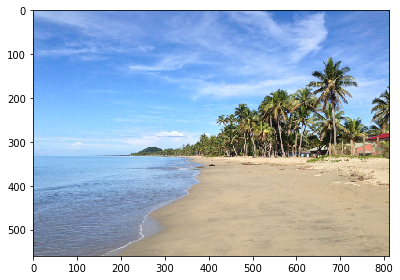

Shape:  (560, 812, 3)
Tile picture:


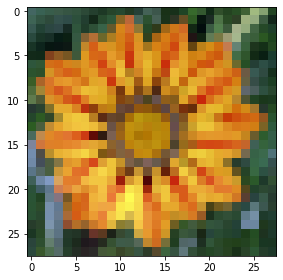

Shape:  (28, 28, 3)


In [15]:
cur_target = get_target_picture('beach2.jpg')
cur_tile = get_tile_picture('flower_small.jpg')
#run_ES(target_pic = cur_target, tile_pic = cur_tile, save_pic = 10, save_path = 'pic-tiles/15col/kwiat_plaza', number_of_tiles = 15, th1 = TH15[1], th2 = TH15[2], th3 = TH15[3], rg1 = RG15[1], rg2 = RG15[2], rg3 = RG15[3])

In [16]:
data = make_tests(tests = 5, target = cur_target, tile_p = cur_tile, _number_of_tiles = 15, _th1 = TH15[1], _th2 = TH15[2], _th3 = TH15[3], _rg1 = RG15[1], _rg2 = RG15[2], _rg3 = RG15[3])

Test  1


100%|█████████████████████████████████████████| 301/301 [36:34<00:00,  7.29s/it]


Test  2


100%|█████████████████████████████████████████| 301/301 [37:54<00:00,  7.55s/it]


Test  3


100%|█████████████████████████████████████████| 301/301 [35:32<00:00,  7.09s/it]


Test  4


100%|█████████████████████████████████████████| 301/301 [31:39<00:00,  6.31s/it]


Test  5


100%|█████████████████████████████████████████| 301/301 [29:29<00:00,  5.88s/it]


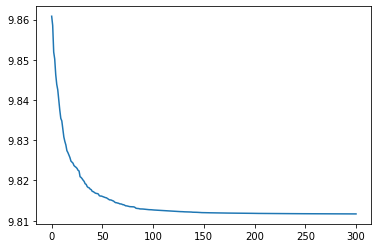

In [17]:
plt.figure()
plt.plot(np.log10(data))
plt.show()

In [18]:
file_to_save = open("pic-tiles/15col/col15kwiat_plaza.txt", "w")
np.savetxt(file_to_save, data)
file_to_save.close()